https://medium.com/swlh/web-scraping-python-requests-and-beautifulsoup-45d5f48f5a1

https://sparkbyexamples.com/spark/spark-read-text-file-rdd-dataframe/

https://medium.com/swlh/text2sql-in-spark-nlp-converting-natural-language-questions-to-sql-queries-on-scale-6ae9a9061d74

https://www.oreilly.com/library/view/learning-spark-2nd/9781492050032/ch04.html

In [90]:
#!python -m pip install html2text

In [92]:
#!python -m pip install mistletoe

In [94]:
#!pip install warcio

In [96]:
#!python -m pip install cdx_toolkit

In [98]:
#!python -m pip install matplotlib

In [100]:
#!python -m pip install pandas

In [102]:
#!python -m pip install sklearn

In [104]:
#!python -m pip install nltk

In [106]:
#%load_ext autoreload
#%autoreload 2

Run the cell below to import everything necessary for this analysis.

In [108]:
import json
import sys
import os.path
import re
import logging
import pandas as pd
import requests
import warcio
import mistletoe
import cdx_toolkit
import zlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from warcio import ArchiveIterator
from contextlib import closing
from html2text import HTML2Text
from bs4 import BeautifulSoup
from pathlib import Path
from IPython.display import HTML as HTML_raw, display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
np.random.seed(0)

# Our corpus

In this analysis, we'll be working with alomost 100k different documents, each containing one single job AD.

These job AD plain text files are contained within the `\c\Users\renjm\Job-Posting-Big-Data\ana\dat\100k_jobADs` subdirectory, contained within the same folder as this analysis. Each job AD is stored in a single file, with files ranging from `1_2021JAN_jobAD.txt` to `99422_2021JAN_jobAD.txt`.

To make it easy to read in all of the documents, use a list comprehension to create a list containing the name of every single job AD plain text file below.

In [110]:
filesList = []
n_0 = 59300
n_1 = 59400
for i in range(n_0, n_1):
    filepath = './dat/100k_jobADs/'+str(i)+'_2021JAN_jobAD.txt'
    if (os.path.exists(filepath)):
        filesList.append(str(i)+'_2021JAN_jobAD.txt')

#print(filesList)

next, create an empty DataFrame called `jobads_df`. As we read in job ads and store and clean them, we'll store them in this DataFrame.

In [112]:
jobads_df = pd.DataFrame()

next, let's import one job AD to see what our text looks like so that we can make sure we clean and tokenize it correctly.

read in and print out the `job description` from `11_2021JAN_jobAD.txt`. Use vanilla Python, no pandas needed.

93148 (113), 59721 (107)

In [114]:
filepick = './dat/100k_jobADs/59306_2021JAN_jobAD.txt' 
with open(filepick, encoding='utf-8', errors='ignore') as f:
    test_jobad = f.readlines()
    print(test_jobad)

['"Profile ICT Officer (Infra) | UNHCR - United Nations High Commissioner for RefugeesBy continuing to browse this site, you agree to our use of cookies. Read our privacy policyI understandToggle navigationJobsCareer resourcesCoachingFor employersSign upSign inProfile ICT Officer (Infra)Multiple locations (Multiple locations)Organization: UNHCR - United Nations High Commissioner for RefugeesLocation: Multiple locations (Multiple locations)Grade: P-2, International Professional - Internationally recruited position - Junior levelOccupational Groups:Information Technology and Computer ScienceClosing Date: 2021-12-31SAVE JOBClick \\"SAVE JOB\\" to save this job description for later.Sign up for free to be able to save this job for later.Associate ICT Officer (Infra)Various Field LocationsGrade: For Junior (P2) and Mid (P3) Level PositionsThe United Nations High Commissioner for Refugees (UNHCR) is mandated to lead and coordinate international action to protect and assist refugees and other

## Tokenizing our Data

Before we can create a bag of words or vectorize each document, we need to clean it up and split each job AD into an array of individual words. Computers are very particular about strings. If we tokenized our data in its current state, we would run into the following problems:

* Counting things that aren't actually words. 
* Punctuation and capitalization would mess up our word counts. To the Python interpreter, `love`, `Love`, `Love?`, and `Love\n` are all unique words, and would all be counted separately. We need to remove punctuation and capitalization, so that all words will be counted correctly.

Tokenization is pretty tedious if we handle it manually, and would probably make use of `regular expressions`. In order to keep this lab moving, we'll use a library function to clean and tokenize our data so that we can move onto vectorization.

Tokenization is a required task for just about any Natural Language Processing (NLP) task, so great industry-standard tools exist to tokenize things for us, so that we can spend our time on more important tasks without getting bogged down hunting every special symbol or punctuation in a massive dataset. For this analysis, we'll make use of the tokenizer in the amazing `nltk` library, which is short for *Natural Language Tool Kit*.

**NOTE**: `NLTK` requires extra installation methods to be run the first time certain methods are used. If `nltk` throws you an error about needing to install additional packages, follow the instructions in the error message to install the dependencies, and then re-run the cell.

Before we tokenize our job AD plain text files, we'll do only a small manual bit of cleaning. In the cell below, a function that allows us to make every word lowercase, remove newline characters `\n`, and all the following punctuation marks: `",.'?!"` is developed.

Furthermore, this function that not only takes in job AD plain text files having erratic symbols removed but also joins all of the lines into a single string. To sum up, the function, `tokenize_jobAD()`, is utilized to get a fully tokenized version of the job AD. We can test this function on `jobad` to ensure that the function works.

In [116]:
def tokenize_jobAD(jobad):
    subs = [('.',''),("'",""),('"',''),(',',''),('?',''),('!',''),('\n',''),('\t',''),('\r',''),('|',''),('/',' '),
            ('-',''),('(c)',''),('*',''),('(',''),(')',''),('&',''),(':',''),(';',''),('[',''),(']',''),('\\',''),
            ('â„¢',''),('%',''),('â£',''),('Â£0',''),('Â£',''),('>',''),('<',''),('=',''),('_',''),('__',''),('“',''),
            ('’',''),('–',''),('”',''),('—',''),('+','')]
    cleaned_jobad = []
    for line in jobad:
        for old, new in subs:
            line = line.replace(old, new).lower()
        cleaned_jobad.append(line)

    tokenized_jobad = ' '.join(cleaned_jobad).split()
    
    return tokenized_jobad

In [118]:
tokenized_test_jobad = tokenize_jobAD(test_jobad)
print(len(tokenized_test_jobad))
print(tokenized_test_jobad[:100000])

968
['profile', 'ict', 'officer', 'infra', 'unhcr', 'united', 'nations', 'high', 'commissioner', 'for', 'refugeesby', 'continuing', 'to', 'browse', 'this', 'site', 'you', 'agree', 'to', 'our', 'use', 'of', 'cookies', 'read', 'our', 'privacy', 'policyi', 'understandtoggle', 'navigationjobscareer', 'resourcescoachingfor', 'employerssign', 'upsign', 'inprofile', 'ict', 'officer', 'inframultiple', 'locations', 'multiple', 'locationsorganization', 'unhcr', 'united', 'nations', 'high', 'commissioner', 'for', 'refugeeslocation', 'multiple', 'locations', 'multiple', 'locationsgrade', 'p2', 'international', 'professional', 'internationally', 'recruited', 'position', 'junior', 'leveloccupational', 'groupsinformation', 'technology', 'and', 'computer', 'scienceclosing', 'date', '20211231save', 'jobclick', 'save', 'job', 'to', 'save', 'this', 'job', 'description', 'for', 'latersign', 'up', 'for', 'free', 'to', 'be', 'able', 'to', 'save', 'this', 'job', 'for', 'laterassociate', 'ict', 'officer', 'in

Now that we can tokenize our job AD plain text file, we can move onto vectorization.

## Count Vectorization

Machine Learning algorithms don't understand strings. However, they do understand math, which means they understand vectors and matrices. By Vectorizing the text, we just convert the entire text into a vector, where each element in the vector represents a different word. The vector is the length of the entire vocabulary -- usually, every word that occurs in the English language, or at least every word that appears in our corpus. Any given sentence can then be represented as a vector where all the vector is 1 (or some other value) for each time that word appears in the sentence.

`Count Vectorization` allows us to represent a sentence as a vector, with each element in the vector corresponding to how many times that word is used. Notice that when we vectorize a sentence this way, we lose the order that the words were in. This is the `Bag of Words` approach

In the cell below, create a function that takes in a tokenized, cleaned job AD plain text file and returns a count vectorized representation of it as a Python dictionary (aka: *Sparse Representation*). Add in an optional parameter called vocab that defaults to None. This way, if we are using a vocabulary that contains words not seen in the song, we can still use this function by passing it into the vocab parameter.

In [120]:
def count_vectorize(jobad, vocab=None):
    if vocab:
        unique_words = vocab
    else:
        unique_words = list(set(jobad))
    
    jobad_dict = {i:0 for i in unique_words}
    
    for word in jobad:
        jobad_dict[word] += 1
    
    return jobad_dict

In [121]:
test_vectorized = count_vectorize(tokenized_test_jobad)
print(test_vectorized)

{'staff': 2, 'good': 3, 'read': 2, 'to': 34, 'this': 7, 'workforce': 4, 'monitor': 1, 'configuration': 1, 'orientation': 1, 'opportunities': 1, 'respond': 1, '9': 1, 'unhcrgeneric': 1, 'free': 2, 'strengthen': 2, 'resourcesbook': 2, 'jobbecome': 2, 'ununhcr': 1, 'continuing': 1, 'diverse': 1, '2': 2, 'headquarter': 1, 'page': 1, 'locationsgrade': 2, 'taught': 1, '4': 1, 'assists': 1, 'seeks': 1, 'is': 5, 'concern': 1, 'do': 1, 'careers': 2, 'duplication': 1, 'applythe': 1, 'office': 1, 'jobclick': 1, 'laterassociate': 1, 'junior': 2, 'delivering': 1, 'masters': 2, 'monitoring': 1, 'applications': 2, 'persons': 1, 'webinar': 1, 'head': 2, 'mayimpactpool': 1, 'nonqualifying': 1, 'browse': 1, 'distinction': 1, 'understanding': 1, 'customer': 1, 'managerapplysave': 1, 'at': 6, 'linux': 1, 'eligibility': 1, 'maintain': 1, 'end': 1, 'infra': 1, 'why': 1, 'required': 1, 'agree': 1, 'may': 2, 'laterrelevant': 1, 'multiple': 4, 'commissioner': 3, 'correct': 1, 'podcast': 2, 'granted': 1, 'opera

We've just successfully vectorized the first job AD plain text document! Now, let's look at a more advanced type of vectorization, TF-IDF!

In [122]:
statesList = ["United States of America","USA","AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS",
              "KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA",
              "RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY","DC","GU","MH","MP","PR","VI","Alabama","Alaska",
              "Arizona","Arkansas","California","Colorado","Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho",
              "Illinois","Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan",
              "Minnesota","Mississippi","Missouri","Montana","Nebraska","Nevada","Hampshire","Jersey","Mexico","York",
              "Carolina","Dakota","Ohio","Oklahoma","Oregon","Pennsylvania","Rhode","Tennessee","Texas","Utah","Vermone",
              "Virginia","Washington","Wisconsin","Wyoming"]
itList = ["Engineer","Scientist","Developer","Analyst","Operator"]
qaList = ["Qualification","Qualifications","Certification","Certifications"]
euList = ["United Kingdom","UK","EU"]

check this text job AD text file to ensure it contains any key word(s) in `qaList`

In [123]:
def qa_usa_Count(filename, tokenized_jobad):
    found_qa = False
    counter_notusa = 0
    counter_qa = 0
    counter_usa = 0
    qaINjobList = []
    qaINusaDict = {}
    
    for eu in euList:
        if eu.lower() in tokenized_jobad.keys():
            counter_notusa += 1
            
    if counter_notusa == 0:
        for qa in qaList:
            if qa.lower() in tokenized_jobad.keys():
                counter_qa += 1
                found_qa = True
                qaINjobList.append(qa)
        if found_qa == True:
            for usa in statesList:
                if usa.lower() in tokenized_jobad.keys():
                    counter_usa += 1
                    qaINusaDict.setdefault(filename, []).append(usa)
            for qa in qaINjobList:
                qaINusaDict.setdefault(filename, []).append(qa)
                
    return counter_qa, counter_usa, qaINusaDict

In [124]:
qaNums_in_test_vectorized, usaNums_in_test_vectorized, qaDict_in_test_vectorized = qa_usa_Count('59306_2021JAN_jobAD', test_vectorized)
print(qaNums_in_test_vectorized)
print(usaNums_in_test_vectorized)
print(qaDict_in_test_vectorized)

1
3
{'59306_2021JAN_jobAD': ['IN', 'ME', 'OR', 'Qualification']}


In [125]:
def get_list_of_qaJobAds():
    n_0 = 1
    n_1 = 100000
    qaPassList = []
    okPassList = []
    okNotPassList = []
    for i in range(n_0, n_1):
        qaNums_in_test_vectorized = 0
        usaNums_in_test_vectorized = 0
        filepath = './dat/100k_jobADs/'+str(i)+'_2021JAN_jobAD.txt'
        if (os.path.exists(filepath)):
            filename = filepath.replace('./dat/100k_jobADs/','').replace('.txt','')
            with open(filepath, encoding='utf-8', errors='ignore') as f:
                test_jobad = f.readlines()
            tokenized_test_jobad = tokenize_jobAD(test_jobad)
            test_vectorized = count_vectorize(tokenized_test_jobad)
            qaNums_in_test_vectorized, usaNums_in_test_vectorized, qaDics_in_test_vectorized = qa_usa_Count(filename, test_vectorized)
            if (qaNums_in_test_vectorized > 0) and (usaNums_in_test_vectorized > 0):
                if (i%3 == 0):
                    qaPassList.append(qaDics_in_test_vectorized) 
                    okPassList.append(i)
            else:
                if (i%18 == 0): 
                    okNotPassList.append(i)
        else:
            continue
                
    return qaPassList, okPassList, okNotPassList

In [126]:
qaPassList, okPassList, okNotPassList = get_list_of_qaJobAds()
print(okPassList)

[69, 81, 105, 135, 186, 207, 225, 234, 243, 294, 348, 603, 615, 627, 741, 780, 879, 882, 891, 903, 915, 978, 984, 1005, 1035, 1077, 1092, 1155, 1167, 1251, 1302, 1308, 1386, 1437, 1440, 1443, 1458, 1518, 1560, 1647, 1665, 1767, 1842, 1866, 1887, 1935, 2034, 2094, 2190, 2208, 2301, 2325, 2331, 2415, 2418, 2430, 2451, 2454, 2484, 2502, 2739, 2868, 2874, 2919, 2943, 2955, 3030, 3033, 3057, 3138, 3252, 3306, 3375, 3507, 3528, 3561, 3639, 3741, 3798, 3801, 3876, 3897, 3909, 3987, 4110, 4152, 4158, 4188, 4215, 4347, 4350, 4353, 4401, 4416, 4431, 4440, 4491, 4566, 4578, 4581, 4686, 4704, 4875, 5037, 5064, 5115, 5205, 5439, 5460, 5481, 5499, 5610, 5619, 5628, 5682, 5685, 5814, 5835, 5850, 6012, 6021, 6054, 6090, 6117, 6156, 6159, 6168, 6198, 6201, 6231, 6240, 6309, 6408, 6429, 6513, 6546, 6696, 6762, 6783, 6834, 6837, 6843, 6855, 6939, 7032, 7035, 7089, 7098, 7110, 7119, 7137, 7170, 7218, 7233, 7269, 7383, 7401, 7491, 7494, 7509, 7533, 7572, 7629, 7647, 7659, 7671, 7710, 7731, 7749, 7779, 7839

In [127]:
print(len(okPassList))
print(len(okNotPassList))

2210
5204


In [128]:
print(okNotPassList)

 44712, 44730, 44748, 44766, 44784, 44802, 44820, 44838, 44856, 44874, 44892, 44910, 44928, 44946, 44964, 44982, 45000, 45018, 45036, 45054, 45072, 45090, 45108, 45126, 45144, 45162, 45180, 45198, 45216, 45234, 45252, 45270, 45288, 45306, 45324, 45342, 45360, 45378, 45396, 45432, 45450, 45468, 45486, 45504, 45522, 45540, 45558, 45576, 45594, 45612, 45630, 45648, 45666, 45684, 45702, 45720, 45738, 45756, 45792, 45810, 45828, 45846, 45864, 45882, 45900, 45918, 45936, 45954, 45972, 45990, 46008, 46026, 46044, 46062, 46080, 46098, 46116, 46134, 46152, 46170, 46188, 46242, 46278, 46296, 46332, 46350, 46368, 46386, 46404, 46422, 46440, 46458, 46476, 46494, 46512, 46530, 46548, 46566, 46584, 46602, 46620, 46638, 46656, 46674, 46692, 46710, 46728, 46746, 46764, 46782, 46800, 46818, 46836, 46854, 46872, 46890, 46908, 46926, 46944, 46962, 46980, 46998, 47016, 47034, 47052, 47070, 47088, 47106, 47124, 47142, 47160, 47178, 47196, 47214, 47232, 47250, 47268, 47286, 47304, 47322, 47340, 47376, 47394

In [129]:
#fout = open('okNotPass.txt', 'w')
#L = list(str(i)+' ' for i in okNotPassList)
#fout.writelines(L)
#fout.close

In [130]:
fout = open('okNotPass.txt', 'w')
for i in okNotPassList:
    fout.write('%d \n' %i)

## TF-IDF Vectorization

TF-IDF stands for *Term Frequency*, *Inverse Document Frequency*. This is a more advanced form of vectorization that weighs each term in a document by how unique it is to the given document it is contained in, which allows us to summarize the contents of a document using a few key words. If the word is used often in many other documents, it is not unique, and therefore probably not too useful if we wanted to figure out how this document is unique in relation to other documents. Conversely, if a word is used many times in a document, but rarely in all the other documents we are considering, then it is likely a good indicator for telling us that this word is important to the document in question.

TF-IDF is used when we have multiple documents. It is based on the idea that rare words contain more information about the content of a document than words that are used many times throughout all the documents. For instance, if we treated every article in a newspaper as a separate document, looking at the amount of times the word "he" or "she" is used probably doesn't tell us much about what that given article is about -- however, the amount of times "touchdown" is used can provide good signal that the article is probably about sports.

The formula TF-IDF uses to determine the weights of each term in a document is *Term Frequency* multiplied by *Inverse Document Frequency*, where the formula for Term Frequency is:

$$\large Term\ Frequency(t) = \frac{number\ of\ times\ t\ appears\ in\ a\ document} {total\ number\ of\ terms\ in\ the\ document} $$

Lets calculate term frequency for every term in a document.

In [131]:
def term_frequency(BoW_dict):
    total_word_count = sum(BoW_dict.values())
    
    for ind, val in BoW_dict.items():
        BoW_dict[ind] = val/total_word_count
    
    return BoW_dict

In [132]:
test = term_frequency(test_vectorized)
print(round(test['qualifications'] if 'qualifications' in test else 0, 6))
print(list(test)[10:20])

0
['respond', '9', 'unhcrgeneric', 'free', 'strengthen', 'resourcesbook', 'jobbecome', 'ununhcr', 'continuing', 'diverse']


Now that we have this, we can easily calculate Inverse Document Frequency. In the cell below, complete the following function. this function should take in the list of dictionaries, with each item in the list being a bag of words representing the words in a different job AD plain text file. The function should return a dictionary containing the inverse document frequency values for each word.

The formula for Inverse Document Frequency is:

$$\large IDF(t) = log_e(\frac{Total\ Number\ of\ Documents}{Number\ of\ Documents\ with\ t\ in\ it})$$

In [133]:
def inverse_document_frequency(list_of_dicts):
    vocab_set = set()
    
    # Iterate through list of dfs and add index to vocab_set
    for d in list_of_dicts:
        for word in d.keys():
            vocab_set.add(word)
    
    # Once vocab set is complete, create an empty dictionary with a key for each word and value of 0.
    full_vocab_dict = {i:0 for i in vocab_set}
    
    # Loop through each word in full_vocab_dict
    for word, val in full_vocab_dict.items():
        docs = 0
        
        # Loop through list of dicts.  Each time a dictionary contains the word, increment docs by 1
        for d in list_of_dicts:
            if word in d.keys():
                docs += 1
        
        # Now that we know denominator for equation, compute and set IDF value for word
        full_vocab_dict[word] = np.log((len(list_of_dicts)/float(docs)))
    
    return full_vocab_dict

## Computing TF-IDF

Now that we can compute both `Term Frequency` and `Inverse Document Frequency`, computing an overall TF-IDF value is simple! All we need to do is multiply the two values.

In the cell below, complete the tf_idf() function. This function should take in a list of dictionaries, just as the inverse_document_frequency() function did. This function returns a new list of dictionaries, with each dictionary containing the `tf-idf vectorized representation` of a corresponding job AD plain text document.

NOTE: Each document should contain the full vocabulary of the entire combined corpus.

In [134]:
def tf_idf(list_of_dicts, okPass=True, dim=2000):
    
    # Create empty dictionary containing full vocabulary of entire corpus
    doc_tf_idf = {}
    idf = inverse_document_frequency(list_of_dicts)
    full_vocab_list = {i:0 for i in list(idf.keys())}
    
    # Create tf-idf list of dictionaries, containing a dictionary that will be updated for each document
    tf_idf_list_of_dicts = []
    
    # Now, compute tf and then use this to compute and set tf-idf values for each document
    for doc in list_of_dicts:
        doc_tf = term_frequency(doc)
        
        if okPass:
            for qa in qaList:
                if qa.lower() in doc_tf.keys():
                    doc_tf_idf[qa.lower()] = round(doc_tf[qa.lower()] * idf[qa.lower()],6)
                
        for word in doc_tf.keys():
            if word not in qaList:
                if len(doc_tf_idf) < dim:
                    doc_tf_idf[word] = round(doc_tf[word] * idf[word],6)
                else: break
            else: continue
                    
        tf_idf_list_of_dicts.append(doc_tf_idf)
    
    return tf_idf_list_of_dicts

## Vectorizing All Documents

Now that we've created all the necessary helper functions, we can load in all of our documents and run each through the vectorization pipeline we've just created.

In the cell below, complete the `main()` function. This function should take in a list of file names (provided for you in the `filenames` list we created at the start), and then:

* Read in each document
* Tokenize each document
* Convert each document to a bag of words (dictionary representation)
* Return a list of dictionaries vectorized using tf-idf, where each dictionary is a vectorized representation of a document

In [135]:
def main(okList, okPass=True, dim=2000):
    
    # Iterate through list of filenames and read each in
    count_vectorized_all_documents = []
    for fileNo in okList:
        filepath = './dat/100k_jobADs/'+str(fileNo)+'_2021JAN_jobAD.txt'
        if (os.path.exists(filepath)):
            with open(filepath, encoding='utf-8', errors='ignore') as f:
                raw_data = f.readlines()
                
        # Clean and tokenize raw text
        tokenized = tokenize_jobAD(raw_data)
        
        # Get count vectorized representation and store in count_vectorized_all_documents  
        count_vectorized_document = count_vectorize(tokenized)
        count_vectorized_all_documents.append(count_vectorized_document)
    
    # Now that we have a list of BoW respresentations of each job AD, create a tf-idf representation of everything
    tf_idf_all_docs = tf_idf(count_vectorized_all_documents, okPass, dim)
    
    return tf_idf_all_docs

In [136]:
tf_idf_okPass_docs = main(okPassList, True, 16000)
print(list(tf_idf_okPass_docs[0])[:10])

['certification', 'judgment', 'staff', 'accesscoordinate', 'space', 'opportunitiescv', 'vaccinepreventable', 'good', 'interpersonal', 'society']


In [137]:
print(tf_idf_okPass_docs[0])

 0.011356, 'standardsresponsible': 0.005813, 'careersautopart': 0.011937, 'partsall': 0.005969, 'multiply': 0.005269, 'environmentthe': 0.004978, 'internationalinternshipfollow': 0.005969, 'weather': 0.003847, 'success23': 0.005813, 'partsdate': 0.005969, 'location}}search': 0.011118, 'battery': 0.004568, 'parking': 0.004159, 'installing': 0.004343, 'toxic': 0.005043, 'classwhat': 0.005813, 'careerscareersretailprofessionalcorporatesupply': 0.005969, 'careersretailprofessionalcorporatesupply': 0.005969, 'etcsecondary': 0.005813, 'stores': 0.009768, 'superior': 0.00366, 'pdq': 0.005559, 'leadershipmeet': 0.005969, 'categoryjoin': 0.011937, 'salesperson': 0.010905, 'perception': 0.004527, 'demandsthe': 0.005559, 'cacareers': 0.011937, 'arms': 0.004377, 'catalogs': 0.005559, 'frequently': 0.00334, 'skillsoperating': 0.011626, 'crawl': 0.004978, 'partsthis': 0.005969, 'installs': 0.004859, 'usat': 0.005188, 'subtract': 0.005269, 'uscareershomecultureour': 0.005969, 'partsadvance': 0.005813

In [89]:
tf_idf_okNotPass_docs = main(okNotPassList, False, 16000)
print(list(tf_idf_okNotPass_docs[0])[:10])

['account', 'warning', 'is', 'and', 'to', 'this', 'immediately', 'you', 'expired', 'your']


In [91]:
print(tf_idf_okNotPass_docs[0])

070508': 0.017827, 'tidiga': 0.017827, 'korta': 0.017827, 'brett': 0.013495, 'problematik': 0.017827, 'cookiesjag': 0.015539, 'består': 0.029879, 'ungas': 0.07131, 'människorna': 0.016383, 'avtalantal': 0.017827, 'internetbaserad': 0.017827, '49facklig': 0.017827, 'rikt': 0.016383, 'undanber': 0.014474, 'ytterligare': 0.016383, 'godkännerläs': 0.015539, 'lidköpingnärhälsan': 0.017827, 'tre': 0.012051, 'arbetar': 0.013495, 'ledarskap': 0.017827, 'aktörer': 0.014939, 'psykiska': 0.07131, 'mycket': 0.013773, 'götalandsregionenvästra': 0.016383, 'hundratals': 0.017827, 'grupp': 0.017827, 'närområdet': 0.017827, 'teamet': 0.035655, 'vänligen': 0.016383, 'liv': 0.014095, 'mer': 0.010305, 'erbjuder': 0.027547, 'annonstill': 0.016383, 'konto': 0.010249, 'försäljarevi': 0.016383, 'möter': 0.016383, 'rekryteringsverktygcookies': 0.015539, 'mild': 0.013773, 'lämplighetvälkommen': 0.017827, 'behandlingsinsatser': 0.017827, 'rekryteringsföretag': 0.031077, 'villkor': 0.014095, '67': 0.010742, 'avta

## Visualizing our Vectorizations

Now that we have a tf-idf representation of each document, we can move on to the fun part -- visualizing everything!

In the cell below, examine our dataset to figure out how many dimensions our dataset has.

**HINT**: Remember that every word is its own dimension!

In [93]:
num_okPass_dims = len(tf_idf_okPass_docs[0])
print("Number of okPass Dimensions: {}".format(num_okPass_dims))

Number of okPass Dimensions: 16000


In [95]:
num_okNotPass_dims = len(tf_idf_okNotPass_docs[0])
print("Number of okNotPass Dimensions: {}".format(num_okNotPass_dims))

Number of okNotPass Dimensions: 16000


There are too many dimensions for us to visualize! In order to make it understandable to human eyes, we'll need to reduce it to 2 or 3 dimensions.

To do this, we'll use a technique called **t-SNE** (short for `t-Stochastic Neighbors Embedding`). This is too complex for us to code ourselves, so we'll make use of scikit-learn's implementation of it.

First, we need to pull the words out of the dictionaries stored in `tf_idf_*_docs` so that only the values remain, and store them in lists instead of dictionaries. This is because the t-SNE only works with array-like objects, not dictionaries.

In the cell below, create a list of lists that contains a list representation of the values of each of the dictionaries stored in `tf_idf_*_docs`. The same structure should remain -- e.g. the first list should contain only the values that were in the first dictionary in `tf_idf_*_docs`, and so on.

In [97]:
tf_idf_vals_okPass_list = []

for i in tf_idf_okPass_docs:
    tf_idf_vals_okPass_list.append(list(i.values()))

In [99]:
print(tf_idf_vals_okPass_list[0][:10])

[0.001639, 0.002641, 0.002203, 0.00651, 0.001204, 0.00651, 0.00651, 0.002332, 0.001958, 0.010843]


In [101]:
tf_idf_vals_okNotPass_list = []

for i in tf_idf_okNotPass_docs:
    tf_idf_vals_okNotPass_list.append(list(i.values()))

In [103]:
print(tf_idf_vals_okNotPass_list[0][:10])

[0.009202, 0.175291, 0.004935, 0.004899, 0.017355, 0.00689, 0.132812, 0.019804, 0.002223, 0.03032]


Now that we have only the values, we can use the `TSNE()` class from `sklearn` to transform our data appropriately. In the cell below, instantiate `TSNE()` with `n_components=3`. Then, use the created object's `.fit_transform()` method to transform the data stored in `tf_idf_vals_list` into 3-dimensional data. Then, inspect the newly transformed data to confirm that it has the correct dimensionality.

In [105]:
t_sne_object_3d = TSNE(n_components=3)

In [107]:
transformed_okPass_data_3d = t_sne_object_3d.fit_transform(tf_idf_vals_okPass_list)
transformed_okPass_data_3d

array([[-76.41043  ,  12.557864 ,   3.983639 ],
       [-56.43342  , -93.757515 , -51.47956  ],
       [-40.15331  , -18.406862 , -65.89487  ],
       ...,
       [ 63.619026 , 232.37715  , -52.453793 ],
       [ -9.098305 ,  13.660802 , -17.717628 ],
       [ 10.507473 , -85.01089  ,  -3.4585383]], dtype=float32)

In [109]:
transformed_okNotPass_data_3d = t_sne_object_3d.fit_transform(tf_idf_vals_okNotPass_list)
transformed_okNotPass_data_3d

array([[ 15.325882 ,  -7.6199327,  49.649647 ],
       [-15.972424 ,  19.483068 ,  26.653458 ],
       [100.240234 ,  -3.0001585,  -9.388569 ],
       ...,
       [-25.342642 ,  52.86951  , -40.441864 ],
       [-87.92203  ,  23.88469  , -37.9936   ],
       [ 18.784132 , -12.816897 ,  44.331043 ]], dtype=float32)

We'll also want to check out how the visualization looks in 2d. Repeat the process above, but this time, instantiate `TSNE()` with 2 components instead of 3. Again, use `.fit_transform()` to transform the data and store it in the variable below, and then inspect it to confirm the transformed data has only 2 dimensions.

In [111]:
t_sne_object_2d = TSNE(n_components=2)

In [113]:
transformed_okPass_data_2d = t_sne_object_2d.fit_transform(tf_idf_vals_okPass_list)
transformed_okPass_data_2d

array([[-1.8427773 ,  0.04982015],
       [-0.74233246,  1.3547041 ],
       [ 1.6796447 , -0.4977452 ],
       ...,
       [-0.09372831, -0.35474983],
       [-0.0941023 , -0.35509822],
       [-0.10087261, -0.38212195]], dtype=float32)

In [115]:
transformed_okNotPass_data_2d = t_sne_object_2d.fit_transform(tf_idf_vals_okNotPass_list)
transformed_okNotPass_data_2d

array([[-0.83411914,  1.3722311 ],
       [-0.90161216, -1.5729911 ],
       [-1.286647  , -0.09746695],
       ...,
       [ 0.14593123, -0.15443459],
       [ 0.81283593, -0.22815694],
       [-0.56929976,  0.09654291]], dtype=float32)

Now, let's visualize everything! Run the cell below to view both 3D and 2D visualizations of job AD plain text files

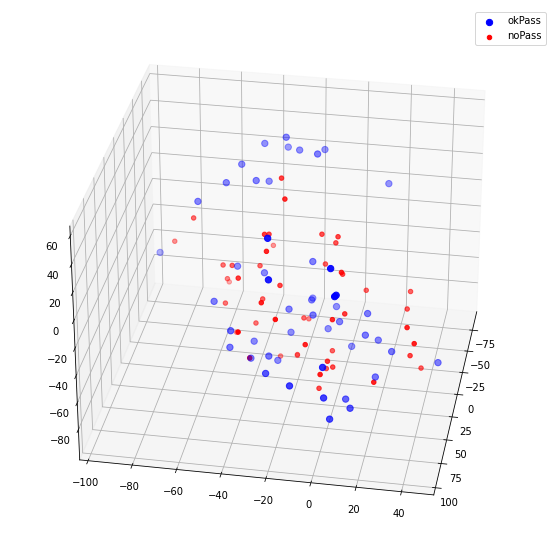

In [117]:
okPass_3d = transformed_okPass_data_3d[:50]
y3_x = [i[0] for i in okPass_3d]
y3_y = [i[1] for i in okPass_3d]
y3_z = [i[2] for i in okPass_3d]

okNotPass_3d = transformed_okNotPass_data_3d[50:101]
n3_x = [i[0] for i in okNotPass_3d]
n3_y = [i[1] for i in okNotPass_3d]
n3_z = [i[2] for i in okNotPass_3d]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y3_x, y3_y, y3_z, c='b', s=40, label='okPass')
ax.scatter(n3_x, n3_y, n3_z, c='red', s=20, label='noPass')
ax.view_init(30, 10)
ax.legend()
plt.show()

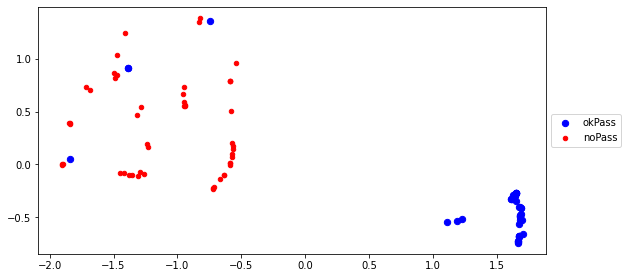

In [119]:
okPass_2d = transformed_okPass_data_2d[:50]
y2_x = [i[0] for i in okPass_2d]
y2_y = [i[1] for i in okPass_2d]

okNotPass_2d = transformed_okNotPass_data_2d[50:101]
n2_x = [i[0] for i in okNotPass_2d]
n2_y = [i[1] for i in okNotPass_2d]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(222)
ax.scatter(y2_x, y2_y, c='b', s=40, label='okPass')
ax.scatter(n2_x, n2_y, c='red', s=20, label='noPass')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

Interesting! Take a crack at interpreting these graphs by answering the following questions below:

What does each graph mean? Do you find one graph more informative than the other? Do you think that this method shows us discernable differences between with and without selected key words such as `qualification`, `qualifications`, `certification` and `certifications`?

Both graphs show a basic trend among the red and blue dots, although the 3-dimensional graph is more informative than the 2-dimensional graph. We see a separation between two groups in which one contains selected key words but the other doesn't. **The words in each group that are common to both are reduced to very small numbers or even down to 0 as a result of the log operation in the IDF function.** This means that the elements of each group vector with the highest values will be the ones that have words that are unique, i.e. selected key words here, to that specific document, or at least are rarely used in others.